In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StringType, TimestampType
from pyspark.sql.functions import window, col, explode, split, length, upper , row_number

# Spark session
spark = (SparkSession
         .builder
         .master('local[1]')
         .appName('twitter-consumer')
         # Add kafka package
         .config("spark.jars.packages", "org.apache.spark:spark-sql-kafka-0-10_2.12:3.1.1")
         .getOrCreate())

In [2]:
# Create stream dataframe setting kafka server, topic and offset option
df = (spark
  .readStream
  .format("kafka")
  .option("kafka.bootstrap.servers", "kafka-server:9092") # kafka server
  .option("subscribe", "tweet-stream") # topic
  .option("startingOffsets", "earliest") # start from beginning 
  .load())

In [3]:
# Convert binary to string key and value
df1 = (df
    .withColumn("timestamp", df["timestamp"].cast(TimestampType()))
    .withColumn("key", df["key"].cast(StringType()))
    .withColumn("value", df["value"].cast(StringType())))

In [4]:
# Explode the text to words
exploded_df = df1.withColumn("crypto", explode(split(col("value"), " " ))).select("timestamp", "crypto")

In [5]:
count_df = exploded_df \
    .filter((exploded_df.crypto.rlike(r'^\#([a-z]{3,4}|[A-Z]{3,4})$')) & (upper(col("crypto"))!='#NFT')) \
    .withWatermark("timestamp", "5 minute") \
    .groupBy(window(col("timestamp"), "5 minute", "10 second"),upper(col("crypto")).alias("crypto")) \
    .count()

In [6]:
queryStream = (count_df
 .writeStream
 .format("memory")
 .queryName("tweet_count")
 .outputMode("append")
 .start())

**********************
General Info
**********************
Run:8
Stream timestamp:2021-10-04T14:52:46.059Z
Watermark:2021-10-04T14:47:36.062Z
Total Rows:3559
Updated Rows:241
Memory used MB:1.08716
**********************
Graph - Top 10 crypto
**********************


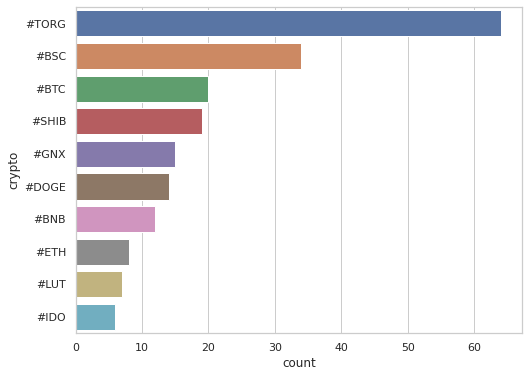

process interrupted.


In [7]:
from time import sleep
from IPython.display import clear_output
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline 

matplotlib.rc('font', family='DejaVu Sans')
sns.set(style="whitegrid")


try:
    i=1
    while True:
        # Clear output
        clear_output(wait=True)
        print("**********************")
        print("General Info")
        print("**********************")
        print("Run:{}".format(i))
        if (len(queryStream.recentProgress) > 0):
            print("Stream timestamp:{}".format(queryStream.lastProgress["timestamp"]))
            print("Watermark:{}".format(queryStream.lastProgress["eventTime"]["watermark"]))
            print("Total Rows:{}".format(queryStream.lastProgress["stateOperators"][0]["numRowsTotal"]))
            print("Updated Rows:{}".format(queryStream.lastProgress["stateOperators"][0]["numRowsUpdated"]))
            print("Memory used MB:{}".format((queryStream.lastProgress["stateOperators"][0]["memoryUsedBytes"]) * 0.000001))
            
        df = spark.sql(
                """
                    select
                        window.start
                        ,window.end
                        ,crypto
                        ,sum(count) count
                    from
                        tweet_count
                    where
                        window.start = (select max(window.start) from tweet_count)
                    group by
                        window.start
                        ,window.end
                        ,crypto
                    order by
                        4 desc
                    limit 10
                """
        ).toPandas()

        # Plot the total crashes
        sns.set_color_codes("muted")

        # Initialize the matplotlib figure
        plt.figure(figsize=(8,6))

        print("**********************")
        print("Graph - Top 10 crypto")
        print("**********************")
        try:
            # Barplot
            sns.barplot(x="count", y="crypto", data=df)

            # Show barplot
            plt.show()
        except ValueError:
            # If Dataframe is empty, pass
            pass

        sleep(10)
        i=i+1
except KeyboardInterrupt:
    print("process interrupted.")